# First try to make a good looking netbook

importing packages

In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import math
import scipy.io
import time
import calendar
from datetime import datetime
import urllib
from sklearn.model_selection import train_test_split

defining steady variables

In [4]:
#Correction between hydrographic 0 and land 0
corr3 = -1.98  # Cap Ferret
#correction niveau moyen en zéro H
nmzh3 = 2.37   # Cap Ferret
g=9.8
densi=1025

Importing Hydrographic Data

In [7]:
#import hydro
DF=pd.read_csv('https://raw.githubusercontent.com/env-models/Beach_erosion/master/datasets/Data_frame.csv',delimiter=';')

Hs=DF['hs']
Time_Hs=DF['# time']
Tp=DF['tp']
setup=DF['setup']
print('first date : ',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(Time_Hs[0])))
print('last date  : ' ,time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(Time_Hs.iloc[-1])))

first date :  2008-01-01 00:00:00
last date  :  2014-12-31 21:00:00


Importing morphological data

In [8]:
local_filename, headers = urllib.request.urlretrieve(r'https://raw.githubusercontent.com/env-models/Beach_erosion/master/datasets/TrucVert_OCA.mat')
Prof = scipy.io.loadmat(local_filename)
x=Prof['x']
x=x[0,:]
z =Prof['z']

Modifying time  so that it fits the Hydrographical one (Time_Hs)

In [12]:
Time_Profil=Prof['date'] #Jours depuis l'an 0
Time_Profil=Time_Profil[0,:]
epoch_matlab= time.strptime("0001-01-01T00:00:00", "%Y-%m-%dT%H:%M:%S")#minus year is 1
epoch_sec=calendar.timegm(epoch_matlab)#secondesde 0 à 1970
var=[X*86400+epoch_sec-365.242*86400-155491 for X in Time_Profil] #adding 1 year here
Time_Profil=var
print('first Profil : ',time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(Time_Profil[0])))
print('last Profil  : ' ,time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(Time_Profil[-1])))


first Profil :  2005-04-08 13:00:00
last Profil  :  2015-06-18 13:00:00


Editing mean profile

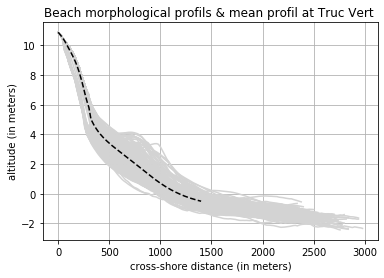

In [22]:
ini=np.searchsorted(Time_Profil,Time_Hs[1],'left')-1
fin=np.searchsorted(Time_Profil,max(Time_Hs),'left')-1
k=range(ini,fin+1)

#Mean Profil: 
Zmoy=[]
for j in range(len(x)):
    Zmoy=np.append(Zmoy,np.mean(z[k,j]))
    
end=min(np.argwhere(np.isnan(Zmoy)))-1
end=int(end)

for i in range(0,len(Time_Profil)):
    plt.plot(z[i,:],'lightgray')
plt.plot(Zmoy,'k--')
plt.xlabel('cross-shore distance (in meters)')
plt.ylabel('altitude (in meters)')
plt.title('Beach morphological profils & mean profil at Truc Vert ')
plt.grid(True)
plt.savefig("T_Vert.png")

plt.show()

Main loop to get the runup

In [18]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

penteS =  []
borneinf=[]
bornesup=[]
runup=[]
SCWmS=[]
HoS=[]
KsS=[]
Lo_inf=[]

for n in range(len(Hs)):
    #print(n)
    ind=np.searchsorted(Time_Profil,Time_Hs[n],'left')-1
    ELE=z[ind,:]
    ELE=ELE[~pd.isnull(ELE)]#Nan off
    DIST=x
    beta = 3#2.14
    Xf=DIST[find_nearest(ELE,beta)]
    
    # pas traduit : Xf(n)=interp1([ELE(Xup),ELE(Xdown)],[DIST(Xup),DIST(Xdown)],beta);
    if (setup[n])< min(ELE):  #% % pas de calcul de pente si le niveau n'atteint pas la fin du profils ou dépasse la crête
        penteS = np.append(penteS,np.nan)
               
    else:
        borneinf = DIST[find_nearest(ELE,setup[n])]
        bornesup = DIST[find_nearest(ELE,4)]
        penteS = np.append(penteS,abs((4-setup[n])/(borneinf-bornesup)))
                
    # %coefficient of Shoaling
    Lo_inf=np.append(Lo_inf,(g*Tp[n]**2)/(2*math.pi))
    tempS=2*math.pi*50/Lo_inf[n]
    KsS=np.append(KsS,math.sqrt(1/(math.tanh(tempS)*(1+2*tempS/math.sinh(2*tempS)))))    
    HoS=np.append(HoS,Hs[n]/KsS[n])
    
    #Final Setup:
    IrrS=penteS[n]/math.sqrt(HoS[n]/Lo_inf[n])
    if pd.isnull(IrrS):
        runup=np.append(runup,np.nan)
        
    elif IrrS<0.3:
        runup=np.append(runup,0.043*math.sqrt(HoS[n]*Lo_inf[n]))
        
    elif IrrS >=0.3:
        runup=np.append(runup,1.1*(0.35*penteS[n]*math.sqrt(HoS[n]*Lo_inf[n])+0.5*(math.sqrt(HoS[n]*Lo_inf[n]*(0.563*(penteS[n]**2)+0.004)))))

   #Niveau modèle, marée + surcôte + runup    
    waterlvlmomS=setup[n]+runup[n]
   #Calcul de l'indicateur
   # if waterlvlmomS<min(ELE):
   #     SCWmS=np.append(SCWmS,np.nan)
    if np.isnan(waterlvlmomS):
        SCWmS=np.append(SCWmS,np.nan)

    else:
        indicewlmon=DIST[find_nearest(ELE,waterlvlmomS)]
        SCWmS=np.append(SCWmS,indicewlmon-Xf)       
    
#END OF LOOP
  

Storm selection

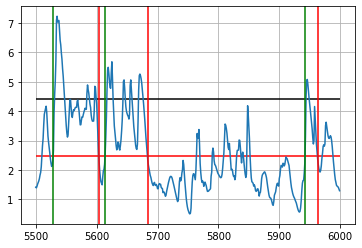

In [20]:

#=====================================================================
#==========DEF EVENEMENT ET   S E U I L   D E    S E L E C T I O N ===
#=====================================================================
seuil1=np.quantile(Hs,.95)      #Seuil hauteur max
seuil2=np.quantile(Hs,.75);     #Seuil début /fin

#=================find start and stop of the storm===================
#====================================================================

 
start=[] #indice de débuts de tempete
stop=[] # indices de fins de tempête

ind_last_storm=max([index for index,value in enumerate(Hs) if value < seuil2])
ind_storm = [i for i in range(ind_last_storm) if Hs[i] > seuil1]

for i in ind_storm:
    
    xxx=[index for index,value in enumerate(Hs[0:i]) if value < seuil2] 
    yyy=[index for index,value in enumerate(Hs[i:-1]) if value < seuil2]
    if xxx:
        start.append(max(xxx))
        stop.append(min(yyy)+i)      
start=sorted(list(set(start)))
stop=sorted(list(set(stop)))

#plot test
i=5500
j=i+500
plt.plot(range(i,j),Hs[i:j])
plt.hlines(seuil1,  i,j, colors='k', linestyles='solid')
plt.hlines(seuil2, i,j, colors='r', linestyles='solid')
 
for xc in start:
    if xc>i and xc<j:
        plt.axvline(x=xc,color='green')
for xc in stop:
        if xc>i and xc<j:
             plt.axvline(x=xc,color='red')
plt.grid()           
plt.show()


R = 0.5427893690451047
rms - train = 237.34795325226494


<function matplotlib.pyplot.show(*args, **kw)>

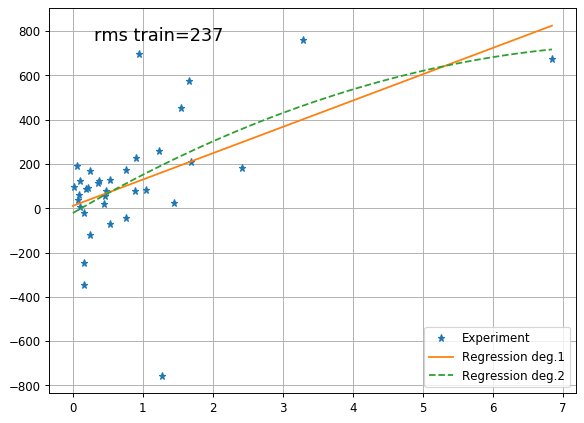

In [23]:





#================================== s l i p ================================

Hs_train, Hs_test=train_test_split(Hs,test_size=0.15, shuffle=False)
Time_train, Time_test=train_test_split(Time_Hs,test_size=0.15, shuffle=False)

#==================================#==================================
#==================================T R A I N ========================
#==================================#==================================
En_sum=[]
Int=[]
V_err=[]
Hs0=np.zeros((len(Hs_train)))
En=np.zeros((len(Hs_train)))

for i in range(0,len(start)):
        if stop[i]<len(Hs_train):
            Hs0[start[i]:stop[i]]=Hs[start[i]:stop[i]]
            
ind = [i for i in range(0,len(Hs_train)) if SCWmS[i]<0] #Energie uniquement quand indicateur depasse le point de calcul
for i in ind:
    En[i]=(1/16*densi*g*(Hs0[i]**2))*3

ini=np.searchsorted(Time_Profil,Time_train[1])
fin=np.searchsorted(Time_Profil,Time_train.iloc[-1])-1 # not to run out oh HS

for i in range(ini,fin-1):
    ti=np.searchsorted(Time_train,Time_Profil[i])
    tf=np.searchsorted(Time_train,Time_Profil[i+1])
    En_sum=np.append(En_sum,sum(En[ti:tf]))
    
En_sum=En_sum/1000000 #passage de J à MJ

#==============Volumes=========

for i in range(ini,fin):
    Int=np.append(Int,np.trapz(z[i,0:end]))

for i in range(0,len(Int)-1):
    V_err=np.append(V_err,Int[i]-Int[i+1])


    
ind = [i for i in range(0,len(En_sum)) if En_sum[i] ==0]     
En_sum=np.delete(En_sum,ind)
V_err=np.delete(V_err,ind)

r=np.polyfit(En_sum,V_err,1)
r2=np.polyfit(En_sum,V_err,2)


#STATES##
i=V_err
j=En_sum*r[0]+r[1]
k=r2[0]*(En_sum**2)+r2[1]*En_sum+r2[2]
#R
#np.corrcoef(i,j)[1,0]
np.corrcoef(i,k)[1,0]
print('R =',np.corrcoef(i,k)[1,0])

#RMSE
from sklearn.metrics import mean_squared_error
rms = math.sqrt(mean_squared_error(i, j))
print('rms - train =',rms)

COEFF_Mod1=r
COEFF_Mod2=r2

#====Final Plot==========

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=85, facecolor='w', edgecolor='k')


xx=np.linspace(0,max(En_sum),100)
plt.plot(En_sum, V_err,'*',label='Experiment')
plt.plot(xx, xx*r[0]+r[1],label='Regression deg.1')
plt.plot(xx, r2[0]*(xx**2)+r2[1]*xx+r2[2],'--',label='Regression deg.2')
plt.text(0.3,max(V_err),'rms train='+str(int(rms)),fontsize=15)
plt.grid()
plt.legend(loc='lower right')
plt.show
#END PLOT##


R-test= 0.8981316696966057
rms-test= 119.67464568355385


<function matplotlib.pyplot.show(*args, **kw)>

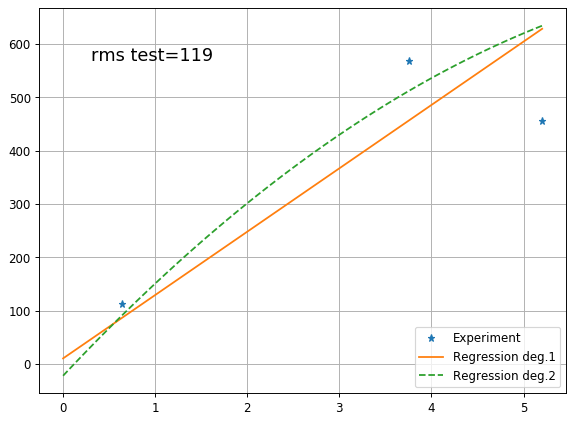

In [24]:

#==================================#==================================
#================================== T E S T ========================
#==================================#==================================
Int=[]
V_err=[]
Hs0=np.zeros((len(Hs)))
En=[]
En_sum=[]
xi=np.searchsorted(start,len(Hs_train))

for i in range(xi,len(start)):
            Hs0[start[i]:stop[i]]=Hs[start[i]:stop[i]]
            
ind = [i for i in range(len(Hs_train),len(Hs)) if SCWmS[i]<0] #Energie uniquement quand indicateur depasse le point de calcul
for i in ind:
    En=np.append(En,(1/16*densi*g*(Hs0[i]**2))*3)

ini=np.searchsorted(Time_Profil,min(Time_test))
fin=np.searchsorted(Time_Profil,Time_test.iloc[-1])-1 # not to run out oh HS
for i in range(ini,fin-1):
    ti=np.searchsorted(Time_test,Time_Profil[i])
    tf=np.searchsorted(Time_test,Time_Profil[i+1])
    En_sum=np.append(En_sum,sum(En[ti:tf]))
    
En_sum=En_sum/1000000 #passage de J à MJ

#==============Volumes=========

for i in range(ini,fin):
    Int=np.append(Int,np.trapz(z[i,0:end]))

for i in range(0,len(Int)-1):
    V_err=np.append(V_err,Int[i]-Int[i+1])
  
ind = [i for i in range(0,len(En_sum)) if En_sum[i] ==0]     
En_sum=np.delete(En_sum,ind)
V_err=np.delete(V_err,ind)

#r=np.polyfit(En_sum,V_err,1)
#r2=np.polyfit(En_sum,V_err,2)


#STATES##
i=V_err
j=En_sum*r[0]+r[1]
k=r2[0]*(En_sum**2)+r2[1]*En_sum+r2[2]
#R
#np.corrcoef(i,j)[1,0]
print('R-test=',np.corrcoef(i,k)[1,0])

#RMSE
from sklearn.metrics import mean_squared_error
rms = math.sqrt(mean_squared_error(i, j))
print('rms-test=',rms)


#====Final Plot==========

figure(num=None, figsize=(8, 6), dpi=85, facecolor='w', edgecolor='k')
xx=np.linspace(0,max(En_sum),100)
plt.plot(En_sum, V_err,'*',label='Experiment')
plt.plot(xx, xx*r[0]+r[1],label='Regression deg.1')
plt.plot(xx, r2[0]*(xx**2)+r2[1]*xx+r2[2],'--',label='Regression deg.2')
plt.grid()
plt.text(0.3,max(V_err),'rms test='+str(int(rms)),fontsize=15)
plt.legend(loc='lower right')
plt.show
#END PLOT##
